In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("gp_data.csv",names = ('X','Y'))

In [3]:
X = data[['X']].to_numpy()
Y = data[['Y']].to_numpy()

X_test = np.linspace(-1, 1, 150).reshape(-1, 1)

In [4]:
#Inicializar

#var_f = Var[y]
#wd**2 = 2/(max(X[:,d]) - min(X[:,d]))
#var_y = 0.01* var_f
var_f =  np.var(Y)
sqWd = 2/(np.max(X, axis = 0) - np.min(X,axis = 0))
var_y = 0.01* var_f


In [5]:
def Rbf_Kernel(X1,X2,sqWd,var_f):
    #(x -y).T(x-y) = x.T@x + yT@y + 2xTy (não vetoriza assim se n != m)
    # X1 = m X d /  X2 = n X d / x1 @ x2.T = m x n
                   
           # m x 1 + n, = m X n
    dist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    # retorna (m X n) 
    return var_f * np.exp(-0.5 * sqWd**2 * dist)
    

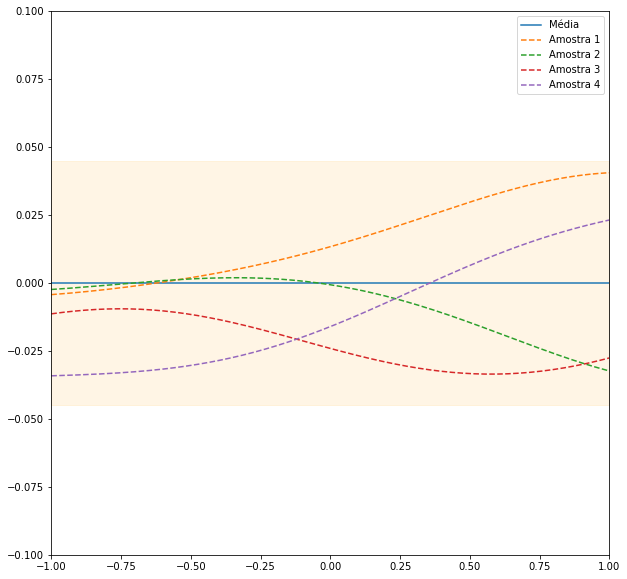

In [6]:
#Priori 
mu = np.zeros(X_test.shape)
cov = Rbf_Kernel(X_test,X_test,sqWd,var_f)
incerteza = 2 * np.sqrt(np.diag(cov))

amostras = np.random.multivariate_normal(mu.ravel(), cov, 4)

plt.figure(figsize=(10,10))
plt.plot(X_test,mu,label = 'Média')
plt.fill_between(X_test.ravel(), mu.ravel() + incerteza, mu.ravel() - incerteza, alpha=0.1,color = 'orange')
plt.ylim(-0.1,0.1)
plt.xlim(-1,1)
for i, amostra in enumerate(amostras):
    plt.plot(X_test, amostra, ls='--', label= f'Amostra {i+1}')
plt.legend()
plt.show()

In [7]:
#posteriori

#X = novas entradas

def posteriori(X_test, X, Y, sqWd, var_f, var_y):
   
    K = Rbf_Kernel(X, X, sqWd, var_f) + var_y * np.eye(len(X))
    Ks = Rbf_Kernel(X, X_test, sqWd, var_f)
    Kss = Rbf_Kernel(X_test, X_test, sqWd, var_f) + var_y * np.eye(len(X_test))
    K_inv = np.linalg.inv(K)
    
    
    mu_s = Ks.T.dot(K_inv).dot(Y)

    
    cov_s = Kss - Ks.T.dot(K_inv).dot(Ks)
    
    return mu_s, cov_s

In [8]:
mu_s, cov_s = posteriori(X_test, X, Y, sqWd, var_f, var_y)

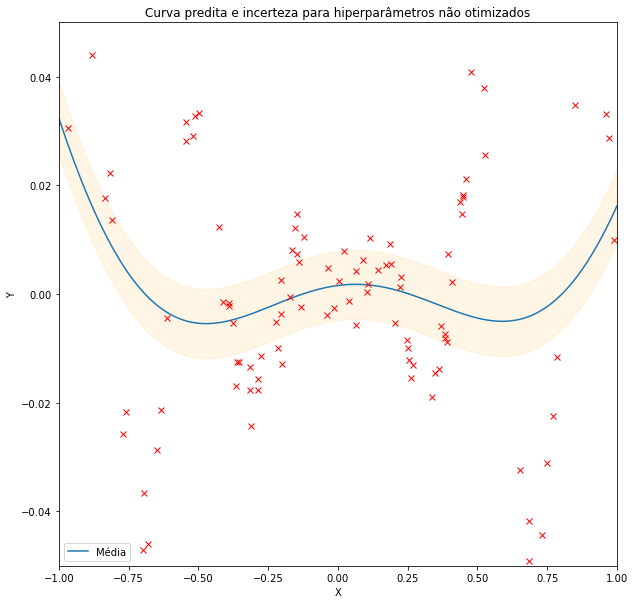

In [9]:
amostras_pos = np.random.multivariate_normal(mu_s.ravel(), cov_s +  var_y * np.eye(len(X_test)), 4)
incerteza = 2 * np.sqrt(np.diag(cov_s +  var_y * np.eye(len(X_test))))

plt.figure(figsize=(10,10))
plt.plot(X_test,mu_s,label = 'Média')
plt.fill_between(X_test.ravel(), mu_s.ravel() + incerteza, mu_s.ravel() - incerteza, alpha=0.1,color = 'orange')
plt.ylim(-0.05,0.05)
plt.xlim(-1,1)
plt.plot(X, Y, 'rx')
#for i, amostra in enumerate(amostras_pos):
    #plt.plot(X_test, amostra, ls='--', label= f'Amostra {i+1}')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Curva predita e incerteza para hiperparâmetros não otimizados')
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error
mu_, cov_ = posteriori(X[0:30], X[30:100], Y[30:100], sqWd, var_f, var_y)

In [11]:
rmse = np.sqrt(mean_squared_error(Y[0:30],mu_))
print(rmse)

0.02114403922243891


In [12]:
var = np.diag(cov_ +  var_y * np.eye(30))
NLPD = 0.5 * np.log(2*np.pi) + (1/(2*30)) * np.sum(np.log(var) + (Y[0:30]-mu_)**2/var)
print(NLPD)

477.39037421230114
